In [1]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

import itertools

from wrangle import wrangle_hud
import preprocessing as pr
from preprocessing import preprocessing_main_function

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

import model


# ignore warnings
import warnings
warnings.simplefilter(action='ignore')

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Acquire
All functions are called in `wrangle.py` file.
## Functions
- `acquire_fha_data.py` - This function takes fha data from hud website (url, sheet_name) turns it into pandas df.
    - url = https://www.hud.gov/sites/dfiles/Housing/documents/Initi_Endores_Firm%20Comm_DB_FY06_FY20_Q2.xlsx
    - sheet_name = "Firm Cmtmts, Iss'd and Reiss'd"
    - The dataset can be physically found at https://www.hud.gov/program_offices/housing/mfh/mfdata/mfproduction

# Prepare
All functions are called in `wrangle.py` file


## Functions

- `drop_multiple_fha_numbers` - Drops repeat entries by taking the most recent option
- `snake_case_column_names` - makes column names snake case
- `change_to_bool` - changes columns with [0, Y] values to bool (Y= True)
- `changing_data_types` - changes dtypes for datetime and turn fha_number into an object
- `make_activity_construction_bool` - makes boolean columns for is_refinance and is_new_construction
- `wrangle_hud` - mother function that also removes lower outlier and does some minor cell changes

In [3]:
df = wrangle_hud()

## Data Summary

In [4]:
print (f'This data frame is {df.shape[0]} rows and {df.shape[1]} columns.')
print ('Currently, each observation is one mortgage, which will change for modelling')
print()
print()
df.info()

This data frame is 20409 rows and 31 columns.
Currently, each observation is one mortgage, which will change for modelling


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20409 entries, 0 to 20514
Data columns (total 31 columns):
 #   Column                                                                Non-Null Count  Dtype         
---  ------                                                                --------------  -----         
 0   fha_number                                                            20409 non-null  object        
 1   project_name                                                          20409 non-null  object        
 2   project_city                                                          20409 non-null  object        
 3   project_state                                                         20409 non-null  object        
 4   basic_fha_risk_share_or_other                                         20409 non-null  object        
 5   program_category   

In [5]:
df.head(2)

,fha_number,project_name,project_city,project_state,basic_fha_risk_share_or_other,program_category,activity_description,activity_group,facility_type,program_designation,...,tax_exempt_bond_designation,home_designation,cdbg_designation,section_202_refi_designation,irp_decoupling_designation,hope_vi_designation,current_status,final_mortgage_amount,is_refinance,is_new_construction
0,11345004,Western Heights Apartments,Olney,TX,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/236,...,False,False,False,False,False,False,Firm Comit then Owner Withdrew,271700,True,False
1,11345005,Woodlands Village Apts,Breckenridge,TX,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/236,...,False,False,False,False,False,False,Finally Endorsed,168300,True,False


Text(0.5, 1.0, 'Histogram of Mortgages by Year')

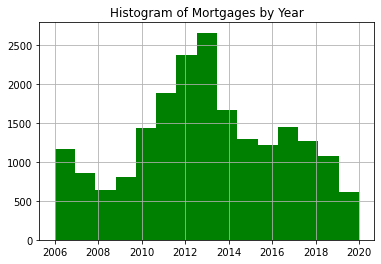

In [6]:
df.fiscal_year_of_firm_commitment_activity.hist(color='green', bins=15)
plt.title('Histogram of Mortgages by Year')

Text(0, 0.5, '')

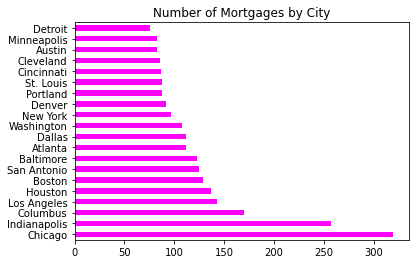

In [7]:
df.groupby('project_city').final_mortgage_amount.count().nlargest(20).plot.barh(color='magenta')
plt.title('Number of Mortgages by City')
plt.ylabel("")

Text(0.5, 1.0, 'Outliers Skewing Mortgage amount Data')

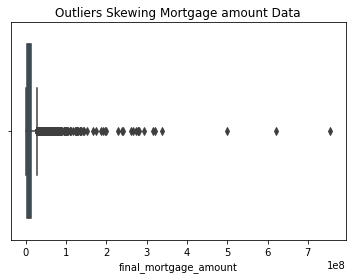

In [8]:
sns.boxplot(df.final_mortgage_amount)
plt.title("Outliers Skewing Mortgage amount Data")

In [9]:
mean_diff = df.final_mortgage_amount.mean()-df.final_mortgage_amount.median()
print(f'The difference between the mean and the median is {round(mean_diff)}')

df.final_mortgage_amount.describe()

The difference between the mean and the median is 4063026


count       20409.00
mean     10785326.03
std      15642874.34
min         70100.00
25%       3420500.00
50%       6722300.00
75%      13295800.00
max     755874500.00
Name: final_mortgage_amount, dtype: float64

# Exploration

# Preprocessing

In order to get our data into a useable format for modeling we decided to group the data by city and state for each fiscal year to get unique observations. Below is a brief summary of the functions found in the `preprocessing.py` script which help to restructure our data into a useable format:

- `get_model_df`: This function wrangles the original data, groups the data using the city, state, and fiscal year features, and aggregates the mortgage data appropriately.
- `calculate_city_state_vol_delta`: This function creates the growth rate for each unique city + state + year observation using total mortgage volume.
- `calculate_city_state_qty_delta`: This function creates the growth rate for each unique city + state + year observation using the quantity of mortgages.
- `calculate_evolution_index`: This function calculates the evolution index using the market volume delta feature created within using the market volume feature. The evolution index is a measure which expresses the growth of a unique city + state + year observation relative to the the overall market growth rate for the whole year.
- `add_new_features`: This function calls `calculate_city_state_vol_delta`, `calculate_city_state_qty_delta`, and `calculate_evolution_index` to add new features to the modeling DataFrame.
- `train_validate_test_data`: This function slipts our data into train, validate, and test for modeling.
- `prep_data_for_modeling`: 
- `labeling_future_data`:  this function creates a label for the data based on whether the quantity of mortgages or volume of mortgages is an outlier.  If it is an outlier the label is `True` in the column `should_enter`. This column becomes the target variable in the modeling dataframes.

In [10]:
model_df = pr.get_model_df()
print(f"""Our modeling DataFrame contains {model_df.shape[0]:,} observations & {model_df.shape[1]} features""")
model_df.head()

Our modeling DataFrame contains 13,507 observations & 12 features


,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label
0,Bronx,NY,2013,8,822430600,102803825.00,24774500.00,nan,nan,nan,nan,False
1,Trenton,NJ,2009,3,760934400,253644800.00,4100000.00,1.00,755874500.00,755874500.00,755874500.00,False
2,New York,NY,2013,6,616362504,102727084.00,18382352.00,1.00,9364704.00,9364704.00,9364704.00,False
3,Chicago,IL,2012,44,510069300,11592484.09,7710000.00,nan,nan,nan,nan,False
4,Chicago,IL,2011,41,462365300,11277202.44,8677500.00,1.00,5387000.00,5387000.00,5387000.00,False


In [11]:
model_df = pr.add_new_features(model_df)
print(f"""Our modeling DataFrame now contains {model_df.shape[0]:,} observations & {model_df.shape[1]} features""")
model_df.head()

Our modeling DataFrame now contains 13,507 observations & 19 features


,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei
7735,Abbeville,LA,2013,1,6500000,6500000.00,6500000.00,nan,nan,nan,nan,False,nan,nan,nan,nan,24940177380,nan,nan
12512,Abbeville,SC,2008,1,1552900,1552900.00,1552900.00,nan,nan,nan,nan,False,nan,nan,nan,nan,4444102426,-0.82,nan
7500,Aberdeen,MD,2006,2,6828000,3414000.00,3414000.00,nan,nan,nan,nan,False,nan,nan,nan,nan,6774129256,nan,nan
1410,Aberdeen,MD,2013,3,34075100,11358366.67,4639800.00,1.00,27247100.00,27247100.00,27247100.00,False,3.99,nan,0.50,nan,24940177380,2.68,1.36
7710,Aberdeen,MD,2015,1,6525000,6525000.00,6525000.00,nan,nan,nan,nan,False,-0.81,0.00,-0.67,0.00,13569931547,-0.46,0.35


### Creating Labels

In [12]:
model_df = pr.labeling_future_data(model_df)

In [13]:
model_df = pr.filter_top_cities(model_df)

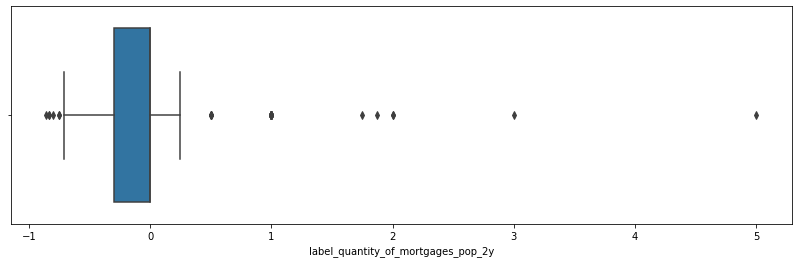

In [14]:
plt.figure(figsize=(14,4))
sns.boxplot(model_df.label_quantity_of_mortgages_pop_2y)


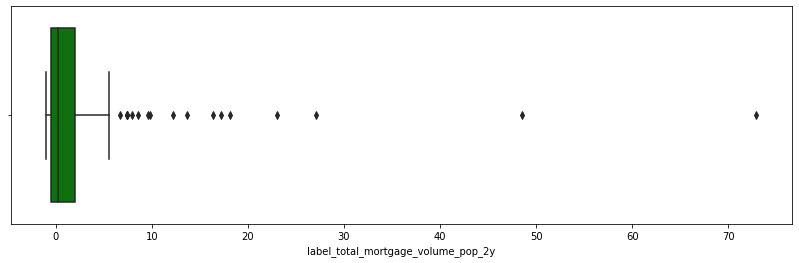

In [15]:
plt.figure(figsize=(14,4))
sns.boxplot(model_df.label_total_mortgage_volume_pop_2y, color='green')

Text(0, 0.5, '')

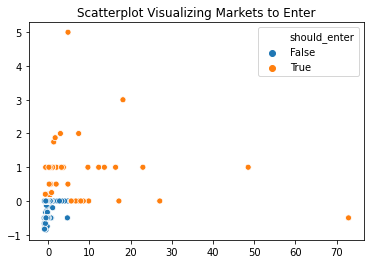

In [16]:
sns.scatterplot(x='label_total_mortgage_volume_pop_2y', y='label_quantity_of_mortgages_pop_2y', data=model_df, hue='should_enter')
plt.title("Scatterplot Visualizing Markets to Enter")
plt.xlabel("")
plt.ylabel("")

---

# Modeling

We will be using classification algorithms to predict what markets will be hot as of 2020/2021. This will help us create recommendations for the future, so that we know what market's will be worth investing resources and labor in, and what martek's are worth ignoring.

We will be likely using the following features for modeling:

```python
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
```

Our target variable (the variable we are trying to predict, will be:

```python
label_feature = "should_enter"
```

In this case, our positive case will be `should_enter_market`. 


When looking at our confusion matrix, and all of it's possible outcomes, it would likely look as follows:

| Matrix | Actual Positive | Actual Negative |
|--------|-----------------|-----------------|
| Predicted Positive | `enter_market` | predicted `not_enter_market`, but really it was a hot market and a missed opportunity | 
| Predicted Negative | predicted `enter_market`, but really it was a cold market, and not worth investing | `not_enter_market`


Traditionally, for a project like this one, we would have focus on reducing the number of `False_Positives`, because it would be far more expensive to the stakeholder if we predicted a city was going to be hot, they spend time and money, and their investment is not returned. However, because TestFit's business strategy and software deployment are all done online, with very little investment needed for traveling. This means that actually investing in a city is not costly at all. As such, we will optimize our models to reduce the number of `False_Negtives`, because we want to make sure we are not missing any potential markets that can be considered `hot markets` in 2020 and 2021.

Given that we have a low number of `positive` labels in our data, we will have to do something called **Oversampling**. This is a practice use in the field to basically help the predictive model by calling attention to the postiive labels and their patterns. We will create duplicate positive values, so that the model becomes more effective at predicting these values.

### Preprocessing

We want to get the data from zero, as to reduce the risk of any information spillage.

In [17]:
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
label_feature = "should_enter"
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = preprocessing_main_function(features_for_modeling, label_feature)

This is how the data will look like before modeling:

In [18]:
train_scaled

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop
Atlanta_GA_2009,0.20,0.34,0.12,0.05
Atlanta_GA_2009,0.20,0.34,0.12,0.05
Atlanta_GA_2009,0.20,0.34,0.12,0.05
Atlanta_GA_2009,0.20,0.34,0.12,0.05
Atlanta_GA_2010,0.25,0.09,0.02,0.06
...,...,...,...,...
Washington_DC_2012,0.10,0.05,0.01,0.15
Washington_DC_2014,0.20,0.05,0.12,0.22
Washington_DC_2015,0.18,0.06,0.04,0.22
Washington_DC_2016,0.18,0.07,0.03,0.36


# Decision Tree

In [19]:
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
label_feature = "should_enter"
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = preprocessing_main_function(features_for_modeling, label_feature)

In [20]:
predictions = pd.DataFrame({"actual": y_train, "baseline": y_train.mode()[0]})

In [21]:
for i in range(1, 20):
    clf, y_pred = model.run_clf(train_scaled, y_train, i)
    score = clf.score(train_scaled, y_train)
    validate_score = clf.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(clf, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 0.67. validate_score = 0.66, recall = 0.70
Max_depth = 2, accuracy_score = 0.73. validate_score = 0.73, recall = 0.91
Max_depth = 3, accuracy_score = 0.75. validate_score = 0.73, recall = 0.91
Max_depth = 4, accuracy_score = 0.79. validate_score = 0.73, recall = 0.96
Max_depth = 5, accuracy_score = 0.83. validate_score = 0.76, recall = 0.96
Max_depth = 6, accuracy_score = 0.88. validate_score = 0.76, recall = 0.97
Max_depth = 7, accuracy_score = 0.89. validate_score = 0.82, recall = 1.00
Max_depth = 8, accuracy_score = 0.94. validate_score = 0.84, recall = 1.00
Max_depth = 9, accuracy_score = 0.97. validate_score = 0.88, recall = 1.00
Max_depth = 10, accuracy_score = 0.98. validate_score = 0.87, recall = 0.99
Max_depth = 11, accuracy_score = 0.99. validate_score = 0.89, recall = 1.00
Max_depth = 12, accuracy_score = 0.99. validate_score = 0.89, recall = 1.00
Max_depth = 13, accuracy_score = 0.99. validate_score = 0.89, recall = 1.00
Max_depth = 14, accur

In [22]:
clf, y_pred = model.run_clf(train_scaled, y_train, 4)
predictions["decision_tree"] = y_pred

In [23]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.79
       False  True 
False     90     71
True      10    219


,False,True,accuracy,macro avg,weighted avg
precision,0.90,0.76,0.79,0.83,0.81
recall,0.56,0.96,0.79,0.76,0.79
f1-score,0.69,0.84,0.79,0.77,0.78
support,161.00,229.00,0.79,390.00,390.00


In [24]:
coef = clf.feature_importances_
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == train_scaled.shape[1])
coef = clf.feature_importances_
columns = train_scaled.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

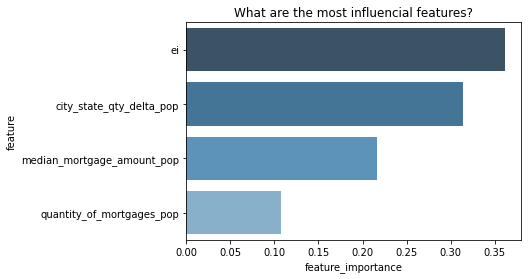

In [25]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

Interestingly, it seems that when it comes to decision tree, the `evolution_index` is actually the most indicative feature, along side the change in number of mortgage's approved. The total `quantity_of_mortgages_pop` doesn't seem to be as influencial in the predictions.

# Random Forest

In [26]:
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
label_feature = "should_enter"
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = preprocessing_main_function(features_for_modeling, label_feature)

In [27]:
for i in range(1, 20):
    rf, y_pred = model.run_rf(train_scaled, y_train, 1, i)
    score = rf.score(train_scaled, y_train)
    validate_score = rf.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(clf, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 0.67. validate_score = 0.60, recall = 0.93
Max_depth = 2, accuracy_score = 0.74. validate_score = 0.76, recall = 0.90
Max_depth = 3, accuracy_score = 0.80. validate_score = 0.79, recall = 0.93
Max_depth = 4, accuracy_score = 0.85. validate_score = 0.81, recall = 0.97
Max_depth = 5, accuracy_score = 0.89. validate_score = 0.84, recall = 0.99
Max_depth = 6, accuracy_score = 0.94. validate_score = 0.88, recall = 1.00
Max_depth = 7, accuracy_score = 0.98. validate_score = 0.90, recall = 1.00
Max_depth = 8, accuracy_score = 0.98. validate_score = 0.91, recall = 1.00
Max_depth = 9, accuracy_score = 0.99. validate_score = 0.92, recall = 1.00
Max_depth = 10, accuracy_score = 1.00. validate_score = 0.93, recall = 1.00
Max_depth = 11, accuracy_score = 1.00. validate_score = 0.92, recall = 1.00
Max_depth = 12, accuracy_score = 1.00. validate_score = 0.93, recall = 1.00
Max_depth = 13, accuracy_score = 1.00. validate_score = 0.92, recall = 1.00
Max_depth = 14, accur

In [28]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 3)
predictions["random_forest"] = y_pred

In [29]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.80
       False  True 
False    100     61
True      17    212


,False,True,accuracy,macro avg,weighted avg
precision,0.85,0.78,0.80,0.82,0.81
recall,0.62,0.93,0.80,0.77,0.80
f1-score,0.72,0.84,0.80,0.78,0.79
support,161.00,229.00,0.80,390.00,390.00


In [30]:
coef = rf.feature_importances_
columns = train_scaled.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

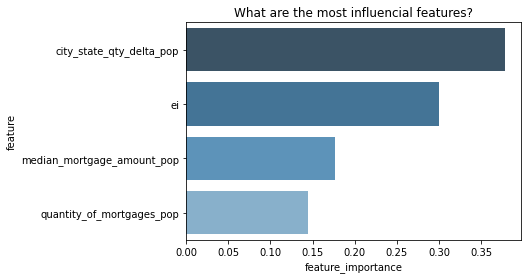

In [31]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

Interestingly, for the random_forest model, the delta of the number of loans approved by city where the most important or influencial indicator of whether a city would be `a hot martket` or not. The evolution index was the second most influencial feature. Again, the total `quantity_of_morgages_pop` was the least influencial feature.

# KNN

In [32]:
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
label_feature = "should_enter"
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = preprocessing_main_function(features_for_modeling, label_feature)

In [33]:
for i in range(1, 20):
    knn, y_pred = model.run_knn(train_scaled, y_train, i)
    score = knn.score(train_scaled, y_train)
    validate_score = knn.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(clf, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 1.00. validate_score = 0.94, recall = 1.00
Max_depth = 2, accuracy_score = 1.00. validate_score = 0.95, recall = 1.00
Max_depth = 3, accuracy_score = 0.92. validate_score = 0.86, recall = 1.00
Max_depth = 4, accuracy_score = 0.91. validate_score = 0.83, recall = 0.98
Max_depth = 5, accuracy_score = 0.84. validate_score = 0.78, recall = 0.98
Max_depth = 6, accuracy_score = 0.84. validate_score = 0.74, recall = 0.94
Max_depth = 7, accuracy_score = 0.80. validate_score = 0.72, recall = 0.95
Max_depth = 8, accuracy_score = 0.77. validate_score = 0.68, recall = 0.86
Max_depth = 9, accuracy_score = 0.76. validate_score = 0.68, recall = 0.88
Max_depth = 10, accuracy_score = 0.71. validate_score = 0.66, recall = 0.71
Max_depth = 11, accuracy_score = 0.72. validate_score = 0.67, recall = 0.77
Max_depth = 12, accuracy_score = 0.72. validate_score = 0.64, recall = 0.75
Max_depth = 13, accuracy_score = 0.75. validate_score = 0.69, recall = 0.85
Max_depth = 14, accur

In [34]:
knn, y_pred = model.run_knn(train_scaled, y_train, 2)
predictions["knn"] = y_pred

In [35]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 1.00
       False  True 
False    161      0
True       0    229


,False,True,accuracy,macro avg,weighted avg
precision,1.00,1.00,1.00,1.00,1.00
recall,1.00,1.00,1.00,1.00,1.00
f1-score,1.00,1.00,1.00,1.00,1.00
support,161.00,229.00,1.00,390.00,390.00


In [36]:
# How do the different models compare on accuracy?
print("Accuracy Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report.accuracy[0]:.2f}')

Accuracy Scores
---------------
Actual = 1.00
Baseline = 0.59
Decision_Tree = 0.79
Random_Forest = 0.80
Knn = 1.00


In [37]:
# How do the different models compare on recall?
print("Recall Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["True"].loc["recall"]:.2f}')

Recall Scores
---------------
Actual = 1.00
Baseline = 1.00
Decision_Tree = 0.96
Random_Forest = 0.93
Knn = 1.00


In [38]:
# How do the different models compare on recall?
print("Precision Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["True"].loc["precision"]:.2f}')

Precision Scores
---------------
Actual = 1.00
Baseline = 0.59
Decision_Tree = 0.76
Random_Forest = 0.78
Knn = 1.00


## Conclusion:

Overall, we see that because we have optimized for *recall*, the accuracy scores are a bit lower than expected. However, our recall scores are really good. We will choose the KNN model as the most effective model, given that it consistently achieved the best scores (for accuracy, recall and precision). 

# Evaluate

In [39]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 3)

In [40]:
y_pred = rf.predict(test_scaled)

In [41]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_test)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.75
       False  True 
False     45     27
True      16     86


,False,True,accuracy,macro avg,weighted avg
precision,0.74,0.76,0.75,0.75,0.75
recall,0.62,0.84,0.75,0.73,0.75
f1-score,0.68,0.80,0.75,0.74,0.75
support,72.00,102.00,0.75,174.00,174.00


---

In [42]:
knn, y_pred = model.run_knn(train_scaled, y_train, 2)

In [43]:
y_pred = knn.predict(test_scaled)

In [44]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_test)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.90
       False  True 
False     55     17
True       0    102


,False,True,accuracy,macro avg,weighted avg
precision,1.00,0.86,0.90,0.93,0.92
recall,0.76,1.00,0.90,0.88,0.90
f1-score,0.87,0.92,0.90,0.89,0.90
support,72.00,102.00,0.90,174.00,174.00


----

# Prediction

In [45]:
df = pr.get_model_df()
df = pr.add_new_features(df)
df = pr.filter_top_cities(df)

In [46]:
df.head()

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state
1474,Atlanta,GA,2006,6,33186800,5531133.33,4457100.00,2.00,9181100.00,4590550.00,4590550.00,False,nan,nan,nan,nan,6774129256,nan,nan,Atlanta_GA
1850,Atlanta,GA,2007,8,28277600,3534700.00,3031150.00,2.00,4541700.00,2270850.00,2270850.00,False,-0.15,-0.51,0.33,0.00,4973263164,-0.27,1.16,Atlanta_GA
7566,Atlanta,GA,2008,2,6735000,3367500.00,3367500.00,1.00,4950000.00,4950000.00,4950000.00,False,-0.76,0.09,-0.75,-0.50,4444102426,-0.11,0.27,Atlanta_GA
752,Atlanta,GA,2009,9,49972900,5552544.44,4400000.00,1.00,3750000.00,3750000.00,3750000.00,False,6.42,-0.24,3.50,0.00,7882704846,0.77,4.18,Atlanta_GA
449,Atlanta,GA,2010,11,68788385,6253489.55,5196100.00,2.00,7203500.00,3601750.00,3601750.00,False,0.38,0.92,0.22,1.00,16193901958,1.05,0.67,Atlanta_GA


In [47]:
features_for_predicting = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]

In [48]:
predictions = df[(df.year == 2020) | (df.year == 2019)].groupby("city_state")[features_for_predicting].mean()
predictions

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop
city_state,,,,
Atlanta_GA,2.50,-0.21,0.82,14743525.00
Austin_TX,4.00,-0.25,1.94,27422850.00
Baltimore_MD,6.50,-0.42,0.97,12466625.00
Boston_MA,12.50,-0.02,1.13,11158750.00
Chicago_IL,11.00,-0.31,0.98,12010100.00
Cincinnati_OH,5.50,0.63,2.96,8620350.00
Cleveland_OH,2.00,0.57,1.57,9025000.00
Dallas_TX,4.00,-0.17,1.30,30065025.00
Detroit_MI,2.00,0.58,8.76,19445600.00


In [49]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values_prediction(scaler, df):
    train_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns.values).set_index([df.index.values])
    return scaler, train_scaled

# Linear scaler
def min_max_scaler_prediction(df):
    scaler = MinMaxScaler().fit(df)
    scaler, df_scaled = return_values_prediction(scaler, df)
    return scaler, df_scaled

In [50]:
scaler, predictions_scaled = min_max_scaler_prediction(predictions)

In [51]:
predictions["label"] = rf.predict(predictions_scaled)

In [52]:
predictions

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop,label
city_state,,,,,
Atlanta_GA,2.50,-0.21,0.82,14743525.00,True
Austin_TX,4.00,-0.25,1.94,27422850.00,True
Baltimore_MD,6.50,-0.42,0.97,12466625.00,False
Boston_MA,12.50,-0.02,1.13,11158750.00,True
Chicago_IL,11.00,-0.31,0.98,12010100.00,True
Cincinnati_OH,5.50,0.63,2.96,8620350.00,True
Cleveland_OH,2.00,0.57,1.57,9025000.00,True
Dallas_TX,4.00,-0.17,1.30,30065025.00,True
Detroit_MI,2.00,0.58,8.76,19445600.00,True


In [53]:
city = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[0]

state = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[1]

In [54]:
predictions = predictions.reset_index()

In [55]:
predictions["city"] = city

predictions["state"] = state

In [56]:
predictions

,city_state,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop,label,city,state
0,Atlanta_GA,2.50,-0.21,0.82,14743525.00,True,Atlanta,GA
1,Austin_TX,4.00,-0.25,1.94,27422850.00,True,Austin,TX
2,Baltimore_MD,6.50,-0.42,0.97,12466625.00,False,Baltimore,MD
3,Boston_MA,12.50,-0.02,1.13,11158750.00,True,Boston,MA
4,Chicago_IL,11.00,-0.31,0.98,12010100.00,True,Chicago,IL
5,Cincinnati_OH,5.50,0.63,2.96,8620350.00,True,Cincinnati,OH
6,Cleveland_OH,2.00,0.57,1.57,9025000.00,True,Cleveland,OH
7,Dallas_TX,4.00,-0.17,1.30,30065025.00,True,Dallas,TX
8,Detroit_MI,2.00,0.58,8.76,19445600.00,True,Detroit,MI
9,Houston_TX,5.00,-0.51,0.52,13573625.00,False,Houston,TX


In [57]:
predictions[predictions.label == True]

,city_state,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop,label,city,state
0,Atlanta_GA,2.50,-0.21,0.82,14743525.00,True,Atlanta,GA
1,Austin_TX,4.00,-0.25,1.94,27422850.00,True,Austin,TX
3,Boston_MA,12.50,-0.02,1.13,11158750.00,True,Boston,MA
4,Chicago_IL,11.00,-0.31,0.98,12010100.00,True,Chicago,IL
5,Cincinnati_OH,5.50,0.63,2.96,8620350.00,True,Cincinnati,OH
6,Cleveland_OH,2.00,0.57,1.57,9025000.00,True,Cleveland,OH
7,Dallas_TX,4.00,-0.17,1.30,30065025.00,True,Dallas,TX
8,Detroit_MI,2.00,0.58,8.76,19445600.00,True,Detroit,MI
10,Indianapolis_IN,7.00,-0.06,1.97,10513825.00,True,Indianapolis,IN
11,Los Angeles_CA,2.00,0.56,5.19,21319100.00,True,Los Angeles,CA


In [58]:
predictions.to_csv("predictions.csv")

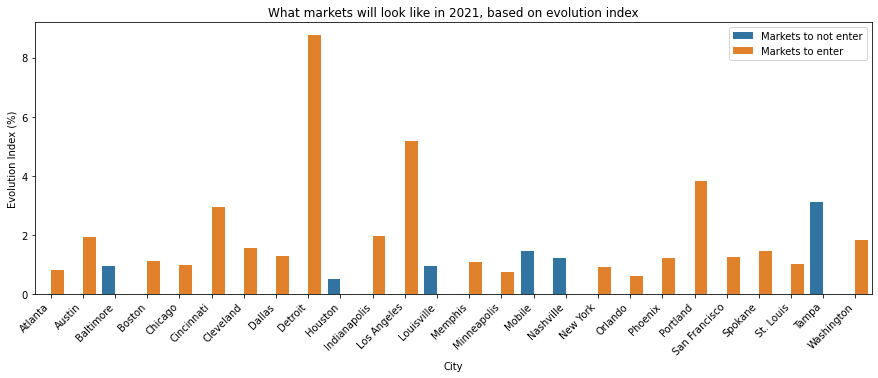

In [59]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=predictions, x="city", y="ei", hue="label")
plt.title("What markets will look like in 2021, based on evolution index")
plt.xticks(rotation=45, ha="right")
plt.xlabel("City")
plt.ylabel("Evolution Index (%)")
new_labels = ['Markets to not enter', 'Markets to enter']
h, l = ax.get_legend_handles_labels()
ax.legend(h, new_labels)
plt.show()